# Calculating RESP charges with pre-computed ESPs

In some cases you may already have computed grids and electrostatic potentials for a known molecule geometry, either using PsiRESP or another library. In this case, you can use a minimal installation of PsiRESP without RDKit, QCFractal, or Psi4 to calculate charges using various methods.


This tutorial presumes that you are already familiar with the basic concepts of RESP charges and using PsiRESP. If not, please see the related notebooks:

* [Calculating charges of one molecule with a temporary server](01_examples_resp_single_server.ipynb)
* [Calculating charges of multiple molecules with a temporary server](02_examples_resp_multi_server.ipynb)

If you have not pre-computed ESPs but you still do not want to use a QCFractal, please see:

* [Calculating RESP charges without a server](03_example_resp_no_server.ipynb)

This tutorial uses the same molecules as [Calculating charges of multiple molecules with a temporary server](02_examples_resp_multi_server.ipynb).

**Pandas** is an optional library used for organising and plotting the data at the end.

In [1]:
import psiresp
import qcelemental as qcel
import numpy as np
import pandas as pd

%matplotlib inline

## Creating the molecules

We load in two molecules from XYZ files. For demonstration purposes, this file is from the PsiRESP testing files.

In [2]:
from psiresp.tests.datafiles import (
    NME2ALA2_OPT_C1,
    METHYLAMMONIUM_OPT
)

We create QCElemental molecules and then PsiRESP molecules, step-by-step. `nme2ala2` will be a simple molecule with only one conformer and one orientation. `methylammonium` will be a slightly more complex molecule with one conformer, and two orientations per conformer, to demonstrate full capability. 

Please see [the documentation on Orientations](https://psiresp.readthedocs.io/en/latest/molecule.html#orientations) for an explanation of why we use multiple orientations for a molecule, and which orientations can be specified or automatically generated.

In [3]:
nme2ala2_c1 = qcel.models.Molecule.from_file(
    NME2ALA2_OPT_C1,
    dtype="xyz",
)
menh3 = qcel.models.Molecule.from_file(
    METHYLAMMONIUM_OPT,
    dtype="xyz",
    molecular_charge=1,
)

It is highly recommended to create PsiRESP molecules by adding Conformers one-by-one, as validation checks are run for each new conformer. You can add a conformer both with `add_conformer` if you are using a QCElemental molecule, or with `add_conformer_with_coordinates` if you only have coordinates. `add_conformer_with_coordinates` allows a `units` keyword for conversion.

In [4]:
nme2ala2 = psiresp.Molecule(qcmol=nme2ala2_c1)
nme2ala2.add_conformer_with_coordinates(nme2ala2_c1.geometry, units="bohr")

Alternatively, if you are only using one conformer, you do not need to directly add a conformer at all.

In [5]:
methylammonium = psiresp.Molecule(qcmol=menh3, charge=1)
methylammonium.generate_transformations(n_reorientations=2)
methylammonium.reorientations

# alternatively, you can specify:
# methylammonium = psiresp.Molecule(
#     qcmol=menh3,
#     reorientations=[(0, 4, 1), (1, 4, 0)],
#     charge=1,
# )

[(0, 4, 1), (1, 4, 0)]

## Adding the grid and ESP values

The grids and ESP values are properties of `psiresp.Orientation` objects. These can be added manually using `Conformer.add_orientation_with_coordinates()`, analogous to `Molecule.add_conformer_with_coordinates()` above. However, if we are not specifying multiple orientations, we can simply use the geometries we passed in initially. This occurs automatically when we call `Molecule.generate_orientations()`.

In [6]:
nme2ala2.generate_orientations()
methylammonium.generate_orientations()

With Orientations generated, we can add the grid and ESP directly to the `Orientation.grid` and `Orientation.esp` properties. Again, we load this from the PsiRESP test data files

In [7]:
import numpy as np
from psiresp.tests.datafiles import (
    NME2ALA2_OPT_C1_GRID,
    NME2ALA2_OPT_C1_ESP,
    METHYLAMMONIUM_O1_GRID,
    METHYLAMMONIUM_O1_ESP,
    METHYLAMMONIUM_O2_GRID,
    METHYLAMMONIUM_O2_ESP,
)

nme2ala2.conformers[0].orientations[0].grid = np.loadtxt(NME2ALA2_OPT_C1_GRID)
nme2ala2.conformers[0].orientations[0].esp = np.loadtxt(NME2ALA2_OPT_C1_ESP)
methylammonium.conformers[0].orientations[0].grid = np.loadtxt(METHYLAMMONIUM_O1_GRID)
methylammonium.conformers[0].orientations[0].esp = np.loadtxt(METHYLAMMONIUM_O1_ESP)
methylammonium.conformers[0].orientations[1].grid = np.loadtxt(METHYLAMMONIUM_O2_GRID)
methylammonium.conformers[0].orientations[1].esp = np.loadtxt(METHYLAMMONIUM_O2_ESP)

## Generating charge constraints

Below, we generate an inter-molecular charge constraint. Without RDKit, we need to specify the constraint with atom indices instead of SMILES or SMARTS. We are able to do this because we specified the geometry ourselves from the XYZ file, so we can use a visualisation program such as `nglview` or VMD to pick out the correct atoms. The below constraint sums the methyl group from `methylammonium` and the acetyl group from `nme2ala2` to equal 0. 

In [8]:
constraints = psiresp.ChargeConstraintOptions()
methyl_atoms = methylammonium.get_atoms(indices=[0, 2, 3, 4])
ace_atoms = nme2ala2.get_atoms(indices=[0, 1, 2, 3, 11, 12, 13, 14])
constraint_atoms = methyl_atoms + ace_atoms
constraints.add_charge_sum_constraint(charge=0, atoms=constraint_atoms)

## Running the job

As previously, we can create a typical psiresp.Job and calculate charges. Instead of calling `Job.run()`, we need to use `Job.compute_charges` -- `Job.run()` will always try to re-compute ESPs, to ensure that they match up to the given grid.

In [9]:
job = psiresp.Job(molecules=[nme2ala2, methylammonium], charge_constraints=constraints)
normal_charges = job.compute_charges()
normal_charges

[array([-0.3479946526284455,  0.0947455215646185,  0.0947455215646185,
         0.0947455215646184,  0.7867893485647182, -0.5839738350665387,
        -0.6944927712231437,  0.3442376495266471,  0.2608201018834638,
         0.3357773566071751, -0.0806738394616683, -0.0806738394616684,
        -0.0806738394616686, -1.2940908358803895,  0.3662001565578509,
         0.3662001565578512,  0.3662001565578511,  0.6748251608445328,
        -0.5559612286597867, -0.5100631453864023,  0.3016945866012605,
        -0.1972274084181829,  0.1129480524175629,  0.1129480524175629,
         0.1129480524175629]),
 array([ 2.4385815262909025, -0.4054676074142619, -0.405467607414262 ,
        -0.4054676074142622, -0.4746498652819122,  0.0544943887160196,
         0.0989882067931542,  0.0989885657246218])]

 The charges above are computed with 2-stage RESP with a hyperbolic restraint, and typical coefficients used in the restraint (`restraint_slope=0.1`, `restraint_height_stage_1=0.0005`, `restraint_height_stage_2=0.001`)

In [10]:
job.resp_options

RespOptions(restraint_slope=0.1, restrained_fit=True, exclude_hydrogens=True, convergence_tolerance=1e-06, max_iter=500, restraint_height_stage_1=0.0005, restraint_height_stage_2=0.001, stage_2=True)

One reason to use PsiRESP, even if you already have pre-computed geometries, grids, and electrostatic potentials, is being able to easily fit charges to different options. For example, changing the restraint slope:

In [11]:
job.resp_options.restraint_slope = 1
slope_1 = job.compute_charges()
slope_1

[array([-0.4545908255000874,  0.1207242780390815,  0.1207242780390815,
         0.1207242780390817,  0.8778592164258321, -0.6057686634879043,
        -0.8459350984200689,  0.381823108747242 ,  0.3771341049247636,
         0.3416614212413097, -0.0904680402945985, -0.0904680402945986,
        -0.0904680402945988, -1.2034314715179415,  0.3327264233352316,
         0.3327264233352314,  0.3327264233352314,  0.6979337100609917,
        -0.5734125251129846, -0.5413040869769363,  0.325712154393496 ,
        -0.267247534312278 ,  0.1335395020984744,  0.1335395020984745,
         0.1335395020984745]),
 array([ 2.4750043684883614, -0.4143512615178306, -0.4143512615178305,
        -0.4143512615178303, -0.5022427252979501,  0.0602535036503358,
         0.1050191406545201,  0.105019497058224 ])]

We might also change the restraint height:

In [12]:
job.resp_options.restraint_height_stage_1 = 1
height_1 = job.compute_charges()
height_1

[array([-0.0247748721379307,  0.052922211872479 ,  0.052922211872479 ,
         0.0529222118724789, -0.0207917828185526, -0.0977226352361417,
        -0.0078511052684009,  0.170124202725129 , -0.0121162862918905,
        -0.0390820673420221,  0.0735757457230962,  0.0735757457230962,
         0.0735757457230963, -1.205388670315887 ,  0.3207989618176216,
         0.3207989618176214,  0.3207989618176218, -0.0439126788205824,
        -0.0951905340534581, -0.0230484017145005,  0.078675143363542 ,
        -0.3664773104777325,  0.1152220800496126,  0.1152220800496127,
         0.1152220800496128]),
 array([ 0.2929154736940858,  0.1617760533253261,  0.1617760533253263,
         0.1617760533253263, -0.0130211267721713,  0.0591071102863873,
         0.0878350394224338,  0.0878353433932856])]

Or turn off charge constraints:

In [13]:
job.charge_constraints.charge_sum_constraints = []
no_constraints = job.compute_charges()
no_constraints

[array([ 0.0327256134724813,  0.0387696031046107,  0.0387696031046106,
         0.0387696031046106, -0.0275298364658156, -0.0942734144329204,
        -0.0112955162349269,  0.150869444329444 , -0.0226591029864556,
         0.3020894839251422, -0.0171308284066392, -0.0171308284066387,
        -0.0171308284066394, -1.2715435478386679,  0.3351008219680786,
         0.3351008219680786,  0.3351008219680786, -0.0537400123476083,
        -0.1082393076648274, -0.0271429788597239,  0.0564909980988714,
        -0.2623954556389083,  0.0888082808819215,  0.0888082808819216,
         0.0888082808819217]),
 array([0.3310875592349877, 0.1505760400696083, 0.1505760400696086,
        0.1505760400696083, 0.0050471750518216, 0.0355065337828089,
        0.0883151243218629, 0.0883154873996936])]

To get an idea for how these changes have affected the output charges, we can organize the methylammonium charges into a [Pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) and plot them.

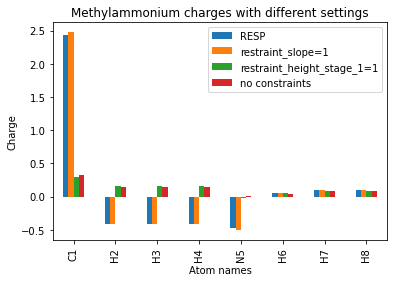

In [14]:
atom_names = [f"{x}{i}" for i, x in enumerate(methylammonium.qcmol.symbols, 1)]

df = pd.DataFrame({
    "Atom names": atom_names,
    "RESP": normal_charges[1],
    "restraint_slope=1": slope_1[1],
    "restraint_height_stage_1=1": height_1[1],
    "no constraints": no_constraints[1]
})

df.set_index("Atom names", inplace=True)

df.plot(ylabel="Charge", title="Methylammonium charges with different settings", kind="bar");

Using Pandas is quite useful; DataFrames can be saved to CSV files, for example, with `df.to_csv()`. They can also simply be viewed as a table in a Jupyter notebook.

In [15]:
df

,RESP,restraint_slope=1,restraint_height_stage_1=1,no constraints
Atom names,,,,
C1,2.438582,2.475004,0.292915,0.331088
H2,-0.405468,-0.414351,0.161776,0.150576
H3,-0.405468,-0.414351,0.161776,0.150576
H4,-0.405468,-0.414351,0.161776,0.150576
N5,-0.474650,-0.502243,-0.013021,0.005047
H6,0.054494,0.060254,0.059107,0.035507
H7,0.098988,0.105019,0.087835,0.088315
H8,0.098989,0.105019,0.087835,0.088315
